# EventVestor: 13D Filings

In this notebook, we'll take a look at EventVestor's *13D Filings* dataset, available on the [Quantopian Store](https://www.quantopian.com/store). This dataset spans January 01, 2007 through the current day, and documents 13D filings with the SEC by activist shareholders disclosing a beneficial ownership of 5% or more.

## Notebook Contents

There are two ways to access the data and you'll find both of them listed below. Just click on the section you'd like to read through.

- <a href='#interactive'><strong>Interactive overview</strong></a>: This is only available on Research and uses blaze to give you access to large amounts of data. Recommended for exploration and plotting.
- <a href='#pipeline'><strong>Pipeline overview</strong></a>: Data is made available through pipeline which is available on both the Research & Backtesting environment. Recommended for custom factor development and moving back & forth between research/backtesting.

### Free samples and limits
One key caveat: we limit the number of results returned from any given expression to 10,000 to protect against runaway memory usage. To be clear, you have access to all the data server side. We are limiting the size of the responses back from Blaze.

There is a *free* version of this dataset as well as a paid one. The free sample includes data until 2 months prior to the current date.

To access the most up-to-date values for this data set for trading a live algorithm (as with other partner sets), you need to purchase acess to the full set.

With preamble in place, let's get started:

<a id='interactive'></a>
#Interactive Overview
### Accessing the data with Blaze and Interactive on Research
Partner datasets are available on Quantopian Research through an API service known as [Blaze](http://blaze.pydata.org). Blaze provides the Quantopian user with a convenient interface to access very large datasets, in an interactive, generic manner.

Blaze provides an important function for accessing these datasets. Some of these sets are many millions of records. Bringing that data directly into Quantopian Research directly just is not viable. So Blaze allows us to provide a simple querying interface and shift the burden over to the server side.

It is common to use Blaze to reduce your dataset in size, convert it over to Pandas and then to use Pandas for further computation, manipulation and visualization.

Helpful links:
* [Query building for Blaze](http://blaze.readthedocs.io/en/latest/queries.html)
* [Pandas-to-Blaze dictionary](http://blaze.readthedocs.io/en/latest/rosetta-pandas.html)
* [SQL-to-Blaze dictionary](http://blaze.readthedocs.io/en/latest/rosetta-sql.html).


Once you've limited the size of your Blaze object, you can convert it to a Pandas DataFrames using:
> `from odo import odo`  
> `odo(expr, pandas.DataFrame)`


###To see how this data can be used in your algorithm, search for the `Pipeline Overview` section of this notebook or head straight to <a href='#pipeline'>Pipeline Overview</a>

In [3]:
# import the dataset
# from quantopian.interactive.data.eventvestor import _13d_filings as dataset
# or if you want to import the free dataset, use:
from quantopian.interactive.data.eventvestor import _13d_filings_free as dataset

# import data operations
from odo import odo
# import other libraries we will use
import pandas as pd

In [4]:
# Let's use blaze to understand the data a bit using Blaze dshape()
dataset.dshape

dshape("""var * {
  event_id: ?float64,
  asof_date: datetime,
  trade_date: ?datetime,
  symbol: ?string,
  event_type: ?string,
  event_headline: ?string,
  percent_shares: ?float64,
  number_shares: ?float64,
  acquiring_entity: ?string,
  event_rating: ?float64,
  timestamp: datetime,
  sid: ?int64
  }""")

In [6]:
# And how many rows are there?
# N.B. we're using a Blaze function to do this, not len()
dataset.count()

1960

In [7]:
# Let's see what the data looks like. We'll grab the first three rows.
dataset[:3]

,event_id,asof_date,trade_date,symbol,event_type,event_headline,percent_shares,number_shares,acquiring_entity,event_rating,timestamp,sid
0,60996,2007-08-21,2007-08-21,GGP,13D Issuer,General Trust Co. Discloses 23.9% Stake in Gen...,23.90,69644773,General Trust Company,1,2007-08-22,8817
1,60998,2007-08-24,2007-08-24,JNC,13D Issuer,UBS Discloses 6.3% stake in Nuveen Investments,6.30,5031458,UBS,1,2007-08-25,4150
2,61003,2007-08-30,2007-08-30,PDE,13D Issuer,SKAGEN Funds discloses 9.03% Stake in Pride In...,9.03,15053900,SKAGEN Funds,1,2007-08-31,6151


Let's go over the columns:
- **event_id**: the unique identifier for this event.
- **asof_date**: EventVestor's timestamp of event capture.
- **trade_date**: for event announcements made before trading ends, trade_date is the same as event_date. For announcements issued after market close, trade_date is next market open day.
- **symbol**: stock ticker symbol of the affected company.
- **event_type**: this should always be *13D Issuer*.
- **event_headline**: a brief description of the event
- **percent_shares**: the percent of shares owned by the investor as per the 13D
- **number_shares**: the number of shares owned by the investor as per the 13D. Note: these shares are not split-adjusted in the way that the rest of our equity data is. We suggest using `percent_shares` with `market cap` (from Fundamentals) to get the total value of shares owned, and dividing by the `close_price` (from price data) to get the number of shares.
- **acquiring_entity**: the investor filing the 13D
- **event_rating**: this is always 1. The meaning of this is uncertain.
- **timestamp**: this is our timestamp on when we registered the data.
- **sid**: the equity's unique identifier. Use this instead of the symbol. Note: this sid represents the  company the shares of which are being purchased, not the acquiring entity.

We've done much of the data processing for you. Fields like `timestamp` and `sid` are standardized across all our Store Datasets, so the datasets are easy to combine. We have standardized the `sid` across all our equity databases.

We can select columns and rows with ease. Below, we'll fetch all 13D filings by Carl Icahn.

In [9]:
# first we find how Icahn is represented exactly in the `acquiring_entity` column
icahns = set(filter(lambda x: "Icahn" in x, dataset.acquiring_entity))
icahns

{u'Carl  C.  Icahn',
 u'Carl C. Icahn',
 u'Carl C. Icahn ',
 u'Carl Icahn',
 u'Icahn Group'}

In [10]:
# Since Carl Icahn is represented in several ways, we use `like` to capture all those ways
names = dataset[dataset.acquiring_entity.like("*Icahn*")]  
# now let's filter down to the percentage of shares, timestamp, and sid  
names = names[['timestamp', 'percent_shares', 'sid', 'acquiring_entity']]  
# # When displaying a Blaze Data Object, the printout is automatically truncated to ten rows.  
names.sort('timestamp')

,timestamp,percent_shares,sid,acquiring_entity
0,2008-05-23,6.54,374,Icahn Group
1,2008-08-12,6.03,3806,Carl C. Icahn
2,2009-12-18,11.28,16820,Carl C. Icahn
3,2010-05-14,11.92,10649,Carl C. Icahn
4,2010-05-28,6.86,4794,Carl C. Icahn
5,2010-06-09,9.67,23311,Carl C. Icahn
6,2010-12-18,5.80,8461,Carl C. Icahn
7,2011-02-12,9.08,1616,Carl C. Icahn
8,2011-06-18,6.95,3014,Carl C. Icahn
9,2011-07-01,9.51,5719,Carl C. Icahn


Finally, suppose we want a DataFrame of all 13D Filings in June 2013:

In [13]:
# we can call odo on the entire dataset
filings_df = odo(dataset, pd.DataFrame)
june = filings_df[(filings_df.timestamp < '2013-07-01') & ('2013-05-31'< filings_df.timestamp)]
june

,event_id,asof_date,trade_date,symbol,event_type,event_headline,percent_shares,number_shares,acquiring_entity,event_rating,timestamp,sid
1740,1593869,2013-06-07,2013-06-07,STEI,13D Issuer,President and Fellows of Harvard College Discl...,6.17,5049950,President and Fellows of Harvard College,1,2013-06-08,7146
1741,1594348,2013-06-10,2013-06-10,BAXS,13D Issuer,James M. Shapiro Discloses 6.9% Stake in Baxan...,6.90,3111419,James M. Shapiro,1,2013-06-11,34871
1742,1594365,2013-06-10,2013-06-11,BAXS,13D Issuer,David Schnell Discloses 11.8% Stake in Baxano ...,11.80,5340616,David Schnell,1,2013-06-11,34871
1743,1594789,2013-06-10,2013-06-11,BAXS,13D Issuer,Wilfred E. Jaeger Discloses 8.2% Stake in Baxa...,8.20,3687896,Wilfred E. Jaeger,1,2013-06-11,34871
1744,1594802,2013-06-12,2013-06-12,ASI,13D Issuer,V. Prem Watsa Discloses 12.6% Stake in America...,12.60,1236214,V. Prem Watsa,1,2013-06-13,18233
1745,1595162,2013-06-17,2013-06-17,SFD,13D Issuer,Jeffrey C. Smith Discloses 5.7% Stake in Smith...,5.70,7962300,Jeffrey C. Smith,1,2013-06-18,6803
1746,1595164,2013-06-17,2013-06-17,AYR,13D Issuer,Marubeni Corporation Discloses 15.25% Stake in...,15.25,12320000,Marubeni Corporation,1,2013-06-18,32475
1747,1595165,2013-06-17,2013-06-18,CCBG,13D Issuer,Douglas W. Smith & E. Drew Mitchell Discloses ...,11.60,2011989,Douglas W. Smith & E. Drew Mitchell,1,2013-06-18,16448
1748,1595166,2013-06-17,2013-06-18,THI,13D Issuer,Adam Weiss Discloses 5.5% Stake in Tim Hortons,5.50,8400000,Adam Weiss,1,2013-06-18,28231
1749,1595180,2013-06-18,2013-06-19,BLC,13D Issuer,Gannett Co. Discloses 10.2% Series A Stake in ...,10.20,10734097,GCI,1,2013-06-19,931


<a id='pipeline'></a>

#Pipeline Overview

### Accessing the data in your algorithms & research
The only method for accessing partner data within algorithms running on Quantopian is via the pipeline API. Different data sets work differently but in the case of this data, you can add this data to your pipeline as follows:

Import the data set here
> `from quantopian.pipeline.data.eventvestor import _13DFilings`

Then in intialize() you could do something simple like adding the raw value of one of the fields to your pipeline:
> `pipe.add(_13DFilings.disclosure_date.latest, 'disclosure_date')`

Pipeline usage is very similar between the backtester and Research so let's go over how to import this data through pipeline and view its outputs.

In [14]:
# Import necessary Pipeline modules
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import AverageDollarVolume

In [15]:
# Import the datasets available
from quantopian.pipeline.data.eventvestor import _13DFilings

# Builtin Factors for easy access
from quantopian.pipeline.factors.eventvestor import BusinessDaysSince13DFilingsDate

Now that we've imported the data, let's take a look at which fields are available for each dataset.

You'll find the dataset, the available fields, and the datatypes for each of those fields.

In [70]:
print "Here are the list of available fields per dataset:"
print "---------------------------------------------------\n"

def _print_fields(dataset):
    print "Dataset: %s\n" % dataset.__name__
    print "Fields:"
    for field in list(dataset.columns):
        print "%s - %s" % (field.name, field.dtype)
    print "\n"

_print_fields(_13DFilings)


print "---------------------------------------------------\n"

Here are the list of available fields per dataset:
---------------------------------------------------

Dataset: _13DFilings

Fields:
disclosure_date - datetime64[ns]
percent_shares - float64
number_shares - float64


---------------------------------------------------



Now that we know what fields we have access to, let's see what this data looks like when we run it through Pipeline.


This is constructed the same way as you would in the backtester. For more information on using Pipeline in Research view this thread:
https://www.quantopian.com/posts/pipeline-in-research-build-test-and-visualize-your-factors-and-filters

In [65]:
pipe = Pipeline()
       
pipe.add(_13DFilings.disclosure_date.latest, "last_disclosure_date")
pipe.add(_13DFilings.percent_shares.latest, "percent_shares")
pipe.add(_13DFilings.number_shares.latest, "number_shares")
pipe.add(BusinessDaysSince13DFilingsDate(), "business_days_since_last_filing")

In [66]:
# Setting some basic liquidity strings (just for good habit)
dollar_volume = AverageDollarVolume(window_length=20)
top_1000_most_liquid = dollar_volume.rank(ascending=False) < 1000

pipe.set_screen(top_1000_most_liquid & BusinessDaysSince13DFilingsDate().notnan())

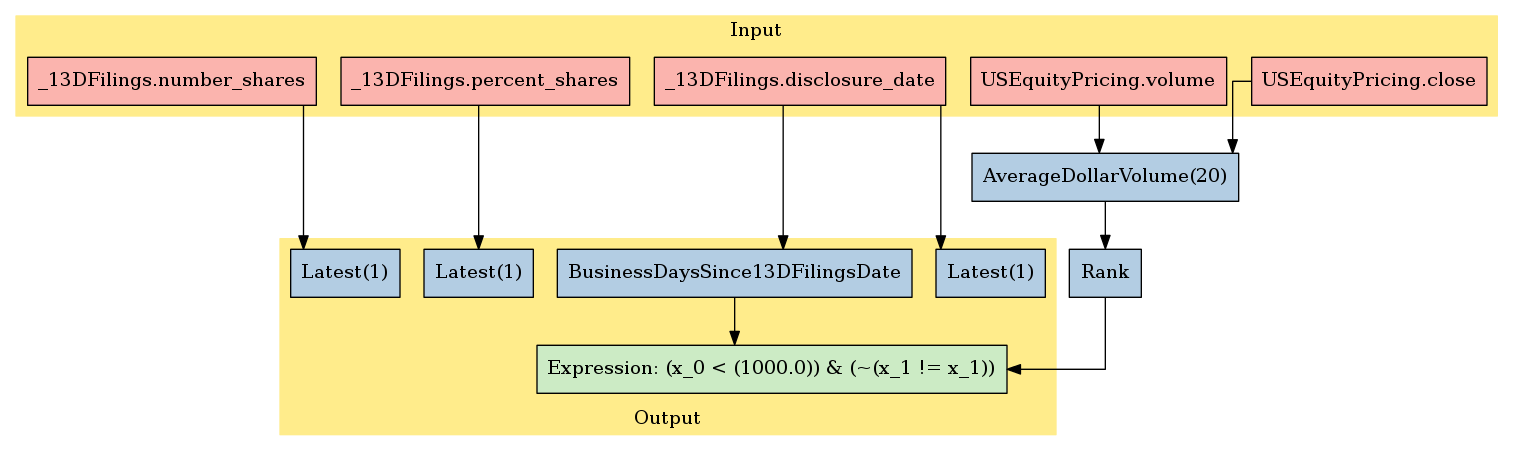

In [67]:
# The show_graph() method of pipeline objects produces a graph to show how it is being calculated.
pipe.show_graph(format='png')

In [68]:
# run_pipeline will show the output of your pipeline
pipe_output = run_pipeline(pipe, start_date='2013-11-01', end_date='2013-11-25')
pipe_output

business_days_since_last_filing  \
2013-11-01 00:00:00+00:00 Equity(717 [BAMM])                                425   
                          Equity(2389 [COBR])                              1036   
                          Equity(2508 [ELSE])                              1020   
                          Equity(2586 [EQS])                               1064   
                          Equity(2902 [STRS])                               472   
                          Equity(3536 [HFFC])                              1027   
                          Equity(3778 [ICCC])                              1239   
                          Equity(3947 [INS])                               1114   
                          Equity(4153 [JOB])                               1121   
                          Equity(4292 [KOSS])                                13   
                          Equity(4351 [LAKE])                              1443   
                          Equity(5281 [NEN])                               1055   
                          Equity(5928 [PFIN])                              1075   
                          Equity(6270 [PWX])                               1136   
                          Equity(6593 [KID])                                521   
                          Equity(7317 [TBAC])                              1332   
                          Equity(7510 [PULS])                               366   
                          Equity(7975 [VIRC])                              1260   
                          Equity(9014 [NTZ])                               1441   
                          Equity(9400 [KTEC])                              1039   
                          Equity(10314 [WVFC])                             1098   
                          Equity(10833 [RGCO])                              864   
                          Equity(11695 [THRD])                              242   
                          Equity(11823 [PNBK])                             1200   
                          Equity(12667 [ALLB])                             1212   
                          Equity(13156 [ATEA])                             1346   
                          Equity(13207 [GVP])                               427   
                          Equity(14098 [LTRE])                              264   
                          Equity(14410 [OVBC])                              168   
                          Equity(14996 [PFBI])                             1397   
...                                                                         ...   
2013-11-25 00:00:00+00:00 Equity(11823 [PNBK])                             1216   
                          Equity(13156 [ATEA])                             1362   
                          Equity(14410 [OVBC])                              184   
                          Equity(15133 [FRBK])                             1416   
                          Equity(15703 [PRLS])                             1189   
                          Equity(16176 [CASM])                             1385   
                          Equity(16420 [UNTY])                             1422   
                          Equity(17281 [PRPH])                              311   
                          Equity(17810 [BASI])                             1210   
                          Equity(19588 [CFBK])                             1027   
                          Equity(20767 [ORBT])                             1109   
                          Equity(20791 [SBSA])                              286   
                          Equity(20847 [CTIB])                             1244   
                          Equity(20974 [FBSS])                             1209   
                          Equity(20987 [HPOL])                             1145   
                          Equity(21566 [TORM])                             1140   
                          Equity(21850 [ARL])                   

Taking what we've seen from above, let's see how we'd move that into the backtester.

In [75]:
# This section is only importable in the backtester
from quantopian.algorithm import attach_pipeline, pipeline_output

# General pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import AverageDollarVolume

# Import the datasets available
from quantopian.pipeline.data.eventvestor import _13DFilings

# Builtin Factors for easy access
from quantopian.pipeline.factors.eventvestor import BusinessDaysSince13DFilingsDate

def make_pipeline():
    # Create our pipeline
    pipe = Pipeline()
    
    # Screen out penny stocks and low liquidity securities.
    dollar_volume = AverageDollarVolume(window_length=20)
    is_liquid = dollar_volume.rank(ascending=False) < 1000
    
    # Create the mask that we will use for our percentile methods.
    base_universe = (is_liquid)

    # Add pipeline factors
    pipe.add(_13DFilings.disclosure_date.latest, "last_disclosure_date")
    pipe.add(_13DFilings.percent_shares.latest, "percent_shares")
    pipe.add(_13DFilings.number_shares.latest, "number_shares")
    pipe.add(BusinessDaysSince13DFilingsDate(), "business_days_since_last_filing")

    # Set our pipeline screens
    pipe.set_screen(is_liquid)
    return pipe

def initialize(context):
    attach_pipeline(make_pipeline(), "pipeline")
    
def before_trading_start(context, data):
    results = pipeline_output('pipeline')

Now you can take that and begin to use it as a building block for your algorithms, for more examples on how to do that you can visit our <a href='https://www.quantopian.com/posts/pipeline-factor-library-for-data'>data pipeline factor library</a>